# Playing with the model outocomes - §§patial Analysis

You need to run the model at least one time to create the snapshot files requeried.

In [1]:
import numpy as np
import yaml # pyyaml library for reading the parameters.yml file
import os
import itertools
import matplotlib.pyplot as plt

from coding.model.opencl.ramp.run import run_headless
from coding.model.opencl.ramp.run import run_opencl
from coding.model.opencl.ramp.snapshot_convertor import SnapshotConvertor
from coding.model.opencl.ramp.snapshot import Snapshot
from coding.model.opencl.ramp.params import Params, IndividualHazardMultipliers, LocationHazardMultipliers
from coding.initialise.initialisation_cache import InitialisationCache
from coding.model.opencl.ramp.simulator import Simulator
from coding.model.opencl.ramp.disease_statuses import DiseaseStatus
from coding.constants import Constants

from coding.model.opencl.ramp.run import run_opencl
from coding.constants import Constants

# Useful for connecting to this kernel
#%connect_info


In [54]:
parameters_file = "/Users/fbenitez/PycharmProjects/RAMP-UA_EcoTwins1709/model_parameters/default.yml"    
try:
    with open(parameters_file, 'r') as f:
        parameters = yaml.load(f,Loader=yaml.SafeLoader)
        sim_params = parameters["microsim"]  # Parameters for the dynamic microsim (python)
        calibration_params = parameters["microsim_calibration"]
        disease_params = parameters["disease"]  # Parameters for the disease model (r)
        #scenario = sim_params["scenario"]
        #initialise = sim_params["initialise"]
        iterations = 120
        study_area = sim_params["study-area"]
        # selected_region_folder_name = sim_params["selected-region-folder-name"]
        #output = sim_params["output"]
        #output_every_iteration = sim_params["output-every-iteration"]
        #debug = sim_params["debug"]
        repetitions = 5
        #use_lockdown = sim_params["use-lockdown"]
        # quant_dir = sim_params["quant-dir"]
        use_cache = sim_params["use-cache"]
        open_cl_model = sim_params["opencl-model"]
        opencl_gui = False
        opencl_gpu = sim_params["opencl-gpu"]
        startDate = sim_params["start-date"]
except Exception as error:
    print('Error in parameters file format')
    raise error

In [28]:
current_risk_beta = disease_params['current_risk_beta']

# Location hazard Multipliers. The OpenCL model incorporates the current risk beta by pre-multiplying the hazard multipliers with it
location_hazard_multipliers = LocationHazardMultipliers(
    retail=calibration_params["hazard_location_multipliers"]["Retail"] * current_risk_beta,
    primary_school=calibration_params["hazard_location_multipliers"]["PrimarySchool"] * current_risk_beta,
    nightclubs=calibration_params["hazard_location_multipliers"]["Nightclubs"] * current_risk_beta,
    secondary_school=calibration_params["hazard_location_multipliers"]["SecondarySchool"] * current_risk_beta,
    home=calibration_params["hazard_location_multipliers"]["Home"] * current_risk_beta,
    work=calibration_params["hazard_location_multipliers"]["Work"] * current_risk_beta,
)

# Individual hazard multipliers can be passed straight through
individual_hazard_multipliers = IndividualHazardMultipliers(
    presymptomatic=calibration_params["hazard_individual_multipliers"]["presymptomatic"],
    asymptomatic=calibration_params["hazard_individual_multipliers"]["asymptomatic"],
    symptomatic=calibration_params["hazard_individual_multipliers"]["symptomatic"]
)

#proportion_asymptomatic = disease_params["asymp_rate"]

params = Params(
    location_hazard_multipliers=location_hazard_multipliers,
    individual_hazard_multipliers=individual_hazard_multipliers,
    #proportion_asymptomatic=proportion_asymptomatic
)

In [34]:
def create_params(calibration_params, disease_params):
    current_risk_beta = disease_params["current_risk_beta"]

    # NB: OpenCL model incorporates the current risk beta by pre-multiplying the hazard multipliers with it
    location_hazard_multipliers = LocationHazardMultipliers(
        retail=calibration_params["hazard_location_multipliers"]["Retail"] * current_risk_beta,
        nightclubs=calibration_params["hazard_location_multipliers"]["Nightclubs"] * current_risk_beta,
        primary_school=calibration_params["hazard_location_multipliers"]["PrimarySchool"] * current_risk_beta,
        secondary_school=calibration_params["hazard_location_multipliers"]["SecondarySchool"] * current_risk_beta,
        home=calibration_params["hazard_location_multipliers"]["Home"] * current_risk_beta,
        work=calibration_params["hazard_location_multipliers"]["Work"] * current_risk_beta,
    )

    individual_hazard_multipliers = IndividualHazardMultipliers(
        presymptomatic=calibration_params["hazard_individual_multipliers"]["presymptomatic"],
        asymptomatic=calibration_params["hazard_individual_multipliers"]["asymptomatic"],
        symptomatic=calibration_params["hazard_individual_multipliers"]["symptomatic"]
    )

    obesity_multipliers = [disease_params["overweight"], disease_params["obesity_30"], disease_params["obesity_35"],
                           disease_params["obesity_40"]]

    return Params(
        location_hazard_multipliers=location_hazard_multipliers,
        individual_hazard_multipliers=individual_hazard_multipliers,
        obesity_multipliers=obesity_multipliers,
        cvd_multiplier=disease_params["cvd"],
        diabetes_multiplier=disease_params["diabetes"],
        bloodpressure_multiplier=disease_params["bloodpressure"],
    )

In [77]:
def run_opencl_model2(i, 
                     iterations,
                     use_gpu,
                     calibration_params,
                     disease_params,
                     parameters_file,
                     store_detailed_counts=True):
                     
    study_area_folder_in_processed_data = ('/Users/fbenitez/PycharmProjects/RAMP-UA_EcoTwins1709/data/processed_data/WY') 
    snapshot_cache_filepath = os.path.join(study_area_folder_in_processed_data, "snapshot", "cache.npz")
    print(f"\n the snapshot we read is located {snapshot_cache_filepath}")
    snapshot = Snapshot.load_full_snapshot(path=snapshot_cache_filepath)

    # set the random seed of the model
    snapshot.seed_prngs(42)

    # set params
    if calibration_params is not None and disease_params is not None:
        snapshot.update_params(create_params(calibration_params, disease_params))

        if disease_params["improve_health"]:
            print("Switching to healthier population")
            snapshot.switch_to_healthier_population()

    simulator = Simulator(snapshot,
                          parameters_file,
                          gpu=use_gpu
                          )
    simulator.upload_all(snapshot.buffers)
    
    run_mode = "headless"

    print(f"\nRunning OpenCL model in {run_mode} mode")
    print(f"Running simulation {i+1}.")
    """
    run_opencl(snapshot,
               study_area,
               parameters_file,
               iterations,
               use_gpu,
               quiet=False
               )
        
    """
    summary, final_state = run_headless(simulator,
                 snapshot,
                 iterations,
                 quiet=False,
                 store_detailed_counts=store_detailed_counts)
    
    
    return summary, final_state
    


In [56]:
""""
run_opencl_model2(individuals,
                 activity_locations,
                 iterations,
                 study_area,
                 opencl_gui,
                 opencl_gpu,
                 calibration_params,
                 disease_params,
                 parameters_file)
"""

'"\nrun_opencl_model2(individuals,\n                 activity_locations,\n                 iterations,\n                 study_area,\n                 opencl_gui,\n                 opencl_gpu,\n                 calibration_params,\n                 disease_params,\n                 parameters_file)\n'

In [78]:
summaries = []
final_results = []

# Prepare the function arguments as lists for starmap

l_i = [i for i in range(repetitions)]
#l_individuals = [individuals] * repetitions
#l_activity_locations = [activity_locations] * repetitions
l_iterations = [iterations] * repetitions
#l_study_area = [study_area] * repetitions
#l_opencl_gui = [opencl_gui] * repetitions
l_opencl_gpu =[opencl_gpu] * repetitions
l_calibration_params = [calibration_params] * repetitions
l_disease_params =[disease_params] * repetitions
l_parameters_file =[parameters_file] * repetitions

results = itertools.starmap( run_opencl_model2, zip(
                l_i,
                #l_individuals,
                #l_activity_locations,
                l_iterations,
                #l_study_area,
                #l_opencl_gui,
                l_opencl_gpu,
                l_calibration_params,
                l_disease_params,
                l_parameters_file))
summaries = [x[0] for x in results]
final_results = [x[1] for x in results]


 the snapshot we read is located /Users/fbenitez/PycharmProjects/RAMP-UA_EcoTwins1709/data/processed_data/WY/snapshot/cache.npz
Checking kernel_dir 	/Users/fbenitez/PycharmProjects/RAMP-UA_EcoTwins1709/coding/model/opencl/ramp/kernels


Running OpenCL model in headless mode
Running simulation 1.


Running simulation: 100%|██████████| 120/120 [00:26<00:00,  4.55it/s]



Day 0
	Susceptible: 1977406
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 0
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 1
	Susceptible: 1977406
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 0
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 2
	Susceptible: 1977406
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 0
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 3
	Susceptible: 1977406
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 0
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 4
	Susceptible: 1977406
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 0
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 5
	Susceptible: 1977406
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 0
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 6
	Susceptible: 1977406
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 0
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 7
	Susceptible: 1977406
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 0
	Symptomatic: 0
	Recovered: 0
	Dead: 0

Day 8
	Susceptible: 1977406
	Exposed: 0
	Presymptomatic: 0
	Asymptomati

Running simulation:  15%|█▌        | 18/120 [00:04<00:22,  4.48it/s]


KeyboardInterrupt: 

In [61]:
def plot_summaries(summaries, plot_type="error_bars"):

    #fig, ax = plt.subplots(1, len(DiseaseStatus), sharey=True)
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    
    # Work out the number of repetitions and iterations
    iters, reps = _get_iters_and_reps(summaries)
    x = range(iters)

    for d, disease_status in enumerate(DiseaseStatus):
        if disease_status==DiseaseStatus.Susceptible or disease_status==DiseaseStatus.Recovered:
            continue
        # Calculate the mean and standard deviation
        matrix = np.zeros(shape=(reps,iters))
        for rep in range(reps):
            matrix[rep] = summaries[rep].total_counts[d]
        mean = np.mean(matrix, axis=0)
        sd = np.std(matrix, axis=0)
        if plot_type == "error_bars":
            ax.errorbar(x, mean, sd, label=f"{disease_status}" )
        elif plot_type == "lines":
            for rep in range(reps):
                ax.plot(x, matrix[rep], label=f"{disease_status} {rep}", 
                        color=plt.cm.get_cmap("hsv", len(DiseaseStatus))(d) )
                
    ax.legend() 
    ax.set_title("Disease Status")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Number of cases")

def _get_iters_and_reps(summaries):
    reps = len(summaries)
    iters = len(summaries[0].total_counts[0])
    return (iters, reps)

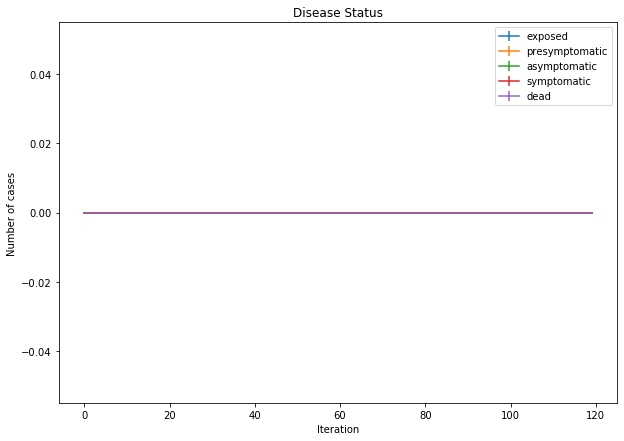

In [62]:
plot_summaries(summaries=summaries, plot_type="error_bars")